In [2]:
import torch
import gpytorch
import numpy as np
import optuna
from src.plotting import plot_gp, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [34]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



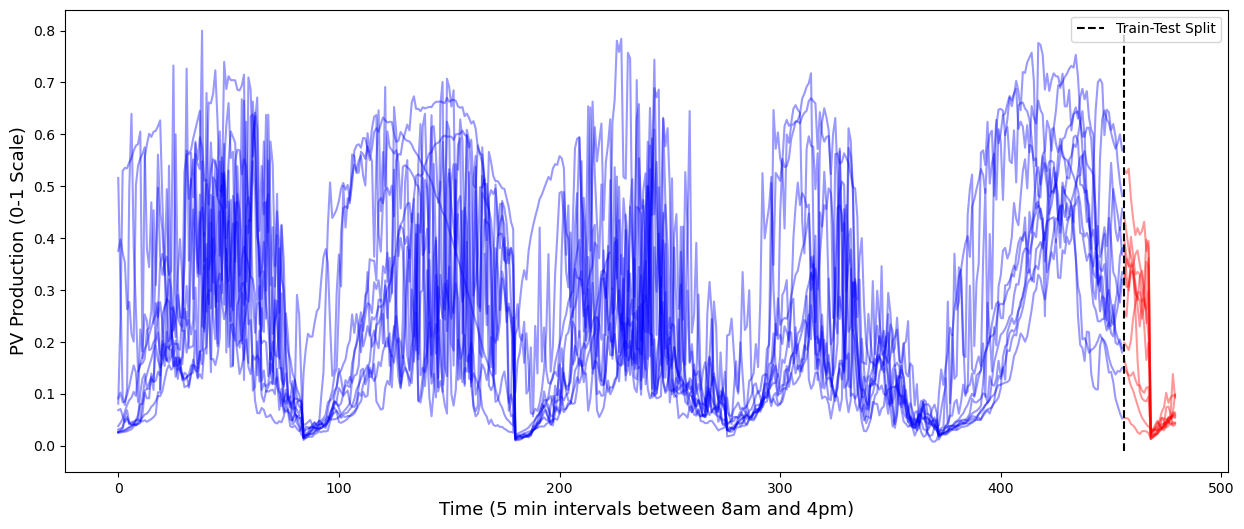

In [35]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
y = torch.clamp(y, min=1e-6, max=1)
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
time = torch.stack([time, periodic_time], dim=-1)

# scale time at 0 dim to [0, 1]
time[:, 0] = time[:,0] / time[:, 0].max()

x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [36]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel)

matern_base = MaternKernel(nu=3/2, 
                      batch_shape=torch.Size([num_latents]),
                    # lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                    # lengthscale_constraint=gpytorch.constraints.Positive()
                    )
periodic = PeriodicKernel(  
                    # period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                    # period_length_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_periodic = ScaleKernel(
                    periodic,
                    # outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                    # outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_matern = ScaleKernel(matern_base, 
                    outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Interval(0.01, 1),
                    batch_shape=torch.Size([num_latents])
                    )
matern_periodic = ScaleKernel(periodic * matern_base,
                    outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )

quasi_periodic_matern = AdditiveKernel(matern_periodic, scaled_matern)

In [58]:
from gpytorch.variational import MeanFieldVariationalDistribution

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self,
                 x_train : torch.Tensor,
                 y_train : torch.Tensor,
                 likelihood : gpytorch.likelihoods.Likelihood = None,
                 mean_module : gpytorch.means.Mean = None,
                 covar_module : gpytorch.kernels.Kernel = None,
                 num_latents : int = 1,
                 jitter : float = 1e-4
                 ):
        # check that num_latents is consistent with the batch_shape of the mean and covar modules
        assert num_latents == mean_module.batch_shape[0], 'num_latents must be equal to the batch_shape of the mean module'
        assert num_latents == covar_module.batch_shape[0], 'num_latents must be equal to the batch_shape of the covar module'

        num_tasks = y_train.size(-1)
       # x_train = x_train.repeat(num_latents, 1, 1)
        
        # MeanField constructs a variational distribution for each output dimension
        variational_distribution = MeanFieldVariationalDistribution(
            x_train.size(-2), batch_shape=torch.Size([num_latents]),jitter=jitter
        )
        
        # LMC constructs MultitaskMultivariateNormal from the base var dist
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, x_train, variational_distribution, learn_inducing_locations=False, jitter_val=jitter
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy)
        
        self.mean_module = mean_module
        self.covar_module =  quasi_periodic_matern
        self.likelihood = likelihood
        self.x_train = x_train
        self.y_train = y_train
        
    def forward(self, x):
    
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
      
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def fit(self, n_iter : int, lr : float, verbose : bool = False):
            
            self.train()
            self.likelihood.train()
            
            mll = gpytorch.mlls.VariationalELBO(self.likelihood, self, num_data=self.y_train.size(0))
            optim = torch.optim.Adam(self.parameters(), lr=lr)
            
            print_freq = n_iter // 10
            
            for i in range(n_iter):
                
                optim.zero_grad()
                output = self(self.x_train)
                loss = -mll(output, self.y_train)
                loss.backward()
                optim.step()
                
                if verbose and (i+1) % print_freq == 0:
                    print(f'Iter {i+1}/{n_iter} - Loss: {loss.item()}')
    
    def predict(self, likelihood, x):
    
        if isinstance(self.likelihood, gpytorch.likelihoods.MultitaskGaussianLikelihood):
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                dist_train = self.likelihood(self(x))
                mean_train = dist_train.mean
                lower_train, upper_train = dist_train.confidence_region()

                return mean_train, lower_train, upper_train
        
        elif isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
            with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(40):
                dist_train = self.likelihood(self(x))
                modes_train = self.likelihood.mode()
                mean_train = modes_train.mean(axis=0)
                lower_train, upper_train = np.quantile(modes_train, q=[0.05, 0.95], axis=0)

                return mean_train, lower_train, upper_train
        
        else:
            raise NotImplementedError('Likelihood not implemented')

In [59]:
model = MultitaskGPModel(x_train=x_train,
                         y_train=y_train,
                         likelihood=gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y_train.size(-1)),
                         mean_module=gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents])),
                         covar_module=quasi_periodic_matern,
                         num_latents=num_latents,
                         jitter=1e-2)

In [60]:
model.fit(n_iter=300, lr=0.1, verbose=True)

Iter 30/300 - Loss: 2.1523211002349854
Iter 60/300 - Loss: -7.211599349975586
Iter 90/300 - Loss: -8.52039909362793
Iter 120/300 - Loss: -8.822798728942871
Iter 150/300 - Loss: -8.903447151184082
Iter 180/300 - Loss: -8.777267456054688
Iter 210/300 - Loss: -8.317002296447754
Iter 240/300 - Loss: -9.044137954711914
Iter 270/300 - Loss: -8.721056938171387
Iter 300/300 - Loss: -9.140286445617676


torch.Size([456, 2]) torch.Size([24, 2])
torch.Size([456, 11]) torch.Size([24, 11])


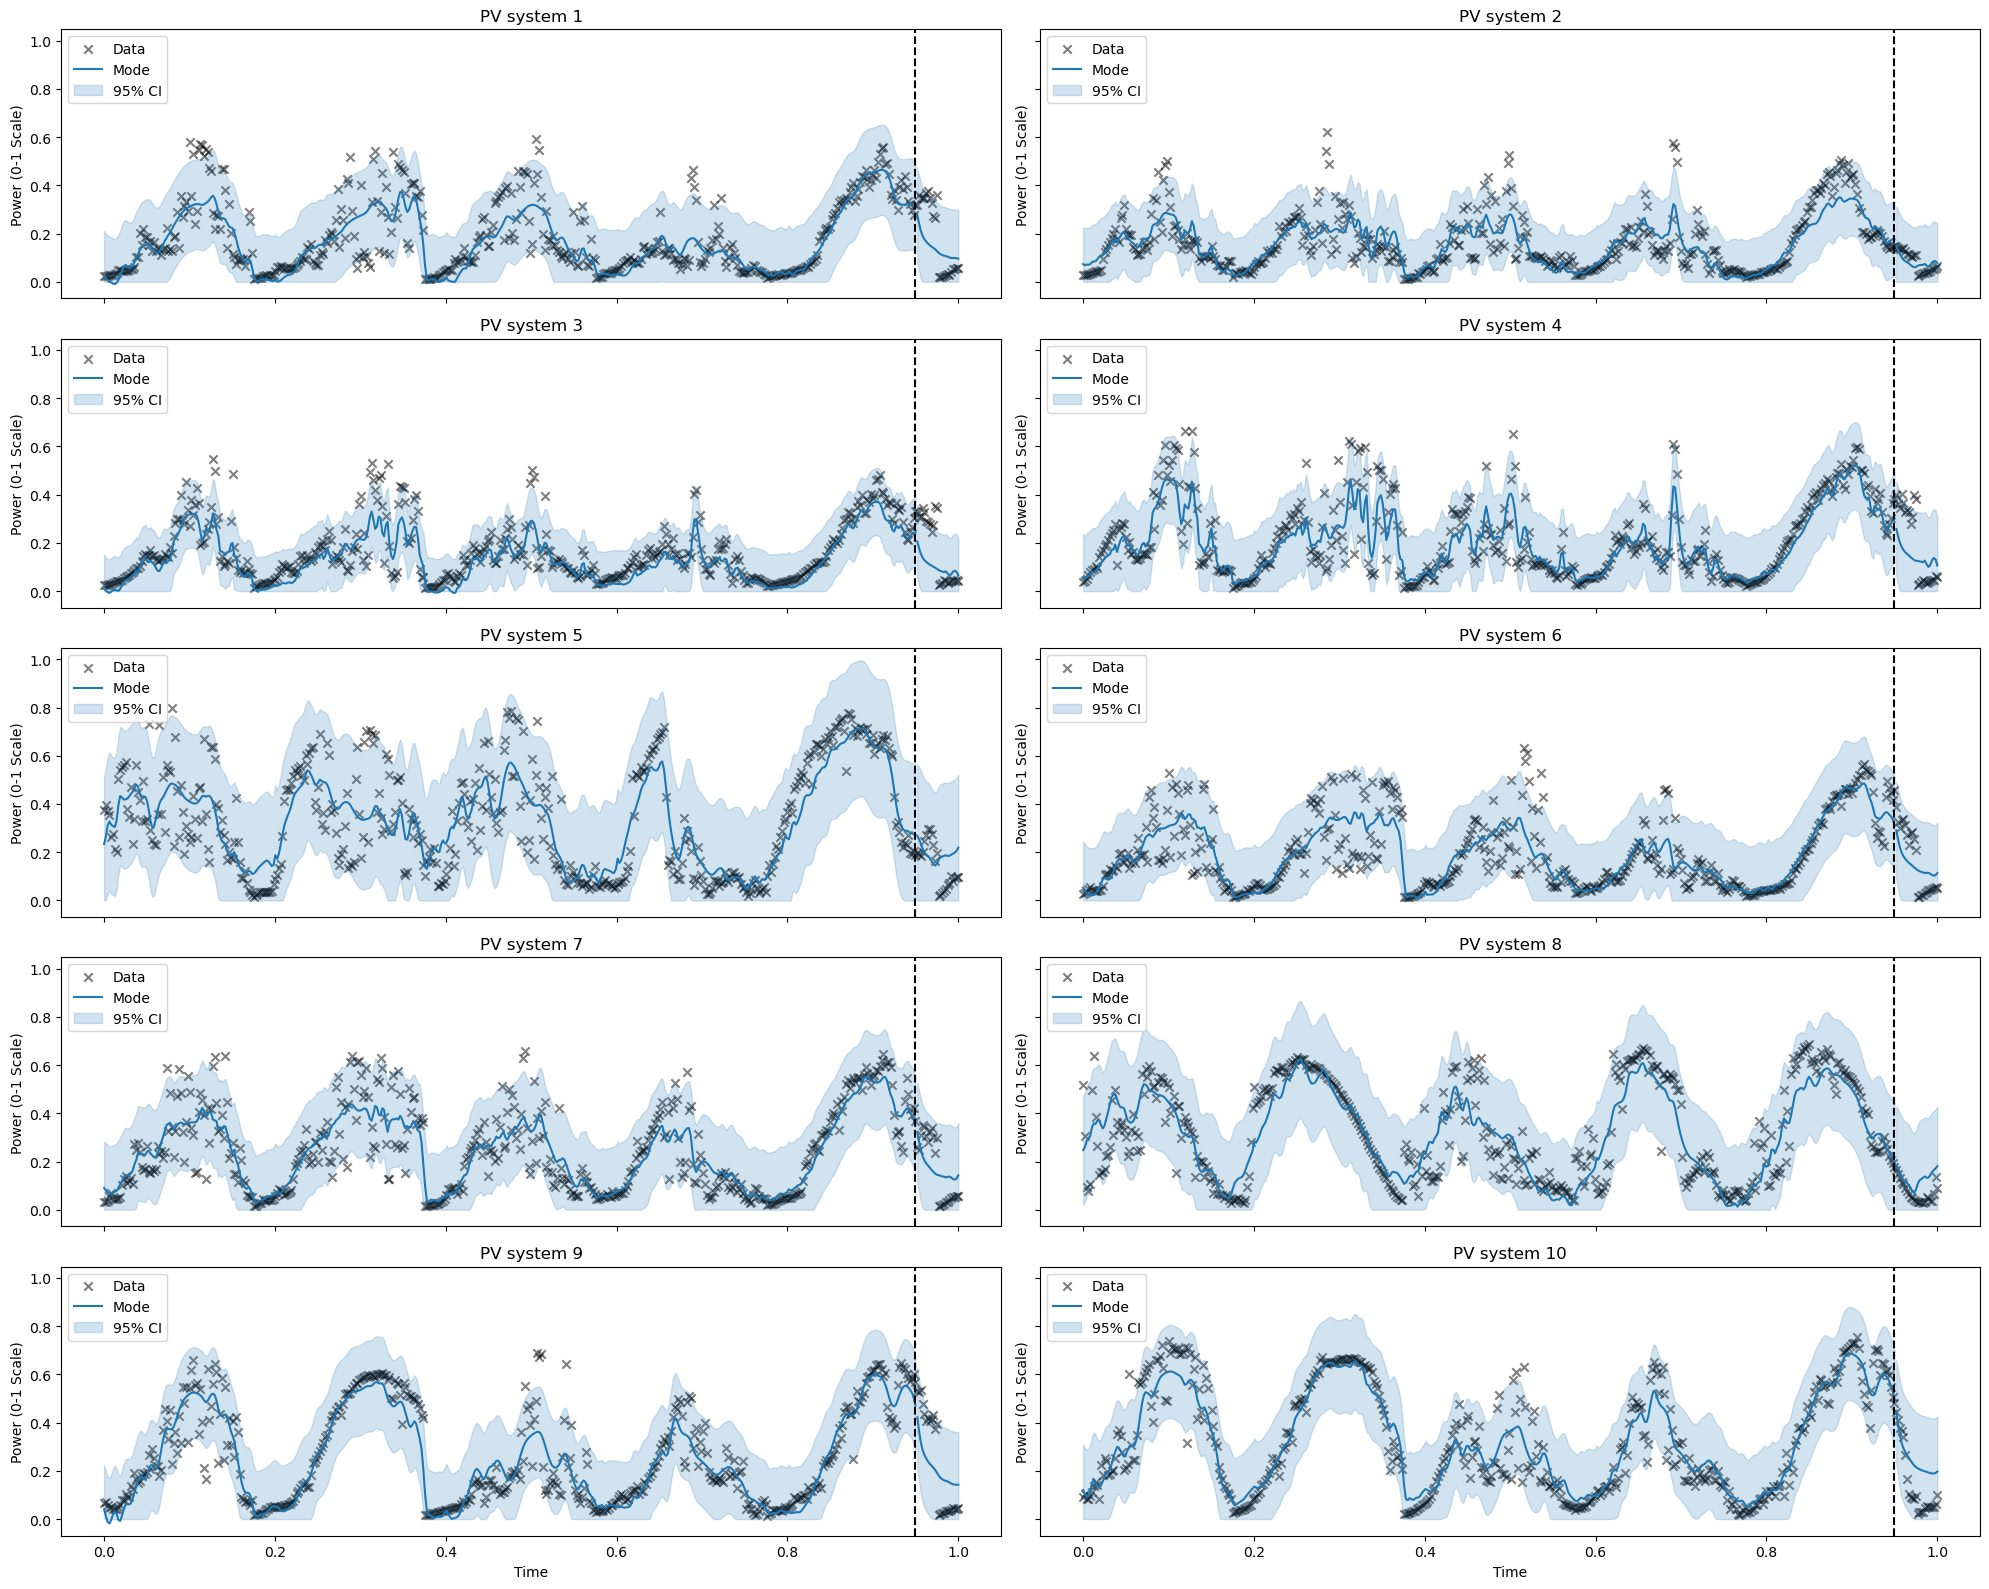

In [62]:
from matplotlib import pyplot as plt

preds_tr, lower_tr, upper_tr = model.predict(model.likelihood, x_train)
preds_te, lower_te, upper_te = model.predict(model.likelihood, x_test)

lower_tr = torch.clamp(lower_tr, min=0, max=1)
upper_tr = torch.clamp(upper_tr, min=0, max=1)
lower_te = torch.clamp(lower_te, min=0, max=1)
upper_te = torch.clamp(upper_te, min=0, max=1)


t_train = x_train[:, 0].detach().cpu().numpy()
t_test = x_test[:, 0].detach().cpu().numpy()

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

n_rows = 5
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 16), sharex=True, sharey=True)

ax = ax.flatten()

for i in range(y_train.size(-1) - 1):
    ax[i].scatter(t_train, y_train[:, i].detach().cpu().numpy(),marker='x', color='k', alpha=0.5)
    ax[i].scatter(t_test, y_test[:, i].detach().cpu().numpy(),marker='x', color='k', alpha=0.5, label='Data')

    ax[i].plot(t_train, preds_tr[:, i].detach().cpu().numpy(), color='C0', label='Mode')
    ax[i].plot(t_test, preds_te[:, i].detach().cpu().numpy(), color='C0')

    ax[i].fill_between(t_train, lower_tr[:, i], upper_tr[:, i], color='C0', alpha=0.2)
    ax[i].fill_between(t_test, lower_te[:, i], upper_te[:, i], color='C0', alpha=0.2, label='95% CI')

    ax[i].axvline(t_train[-1], color='k', linestyle='--')

    if i+1 % 2 != 0:
        ax[i].set_ylabel('Power (0-1 Scale)')

    if i+1 > n_rows * n_cols - n_cols:
        ax[i].set_xlabel('Time')
    
    ax[i].set_title(f'PV system {i+1}')
    ax[i].legend()

plt.tight_layout()
plt.show()